# Training Faster R-CNN for Trash Detection using TACO Dataset

This tutorial walks through the process of training a Faster R-CNN model for detecting trash objects using the TACO dataset. We'll use PyTorch and torchvision's implementation of Faster R-CNN with a ResNet-50 backbone.

# Setting Up the Development Environment and Required Dependencies

This section focuses on importing the essential libraries and tools needed for fine-tuning a Faster R-CNN model with ResNet50 backbone on the TACO (Trash Annotations in Context) dataset. Let's understand what each group of imports contributes to our project:

### PyTorch and Vision Libraries
The first few imports bring in PyTorch and its computer vision toolkit (torchvision), which form the foundation of our deep learning implementation. These provide the core functionality for building and training our object detection model:
```python
import torch
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F
```

### Model-Specific Components
We import specialized components for Faster R-CNN, which is our chosen architecture for trash detection. These imports give us access to the pre-trained ResNet50 backbone and various components needed for object detection:
```python
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.faster_rcnn import (...)
```

### Data Handling and Processing
These imports help us manage our dataset, including loading, splitting, and batching the data:
```python
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from PIL import Image
import json
import pandas as pd
```

### Visualization and Debugging Tools
For monitoring training progress and visualizing results, we import plotting libraries and debugging utilities:
```python
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
```

### Utility Imports
The remaining imports provide supporting functionality for file handling, type checking, parallel processing, and other utility operations that we'll need throughout our training pipeline.

In the following sections, we'll use these libraries to build a complete object detection system capable of identifying various types of trash in images. Understanding these imports is crucial as they provide the building blocks for our entire implementation.

In [1]:
import torch
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.faster_rcnn import (
    fasterrcnn_resnet50_fpn,
    FastRCNNPredictor,
    AnchorGenerator,
    RPNHead
)
import torch.optim as optim
from tqdm import tqdm
from pathlib import Path
import time
import math
from PIL import Image
import json
import os
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import gc
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from typing import Dict, List, Optional, Tuple
from collections import defaultdict, Counter
import threading
from queue import Queue
from contextlib import contextmanager
import time
import cv2
from FasterRCNN import utils
import pickle
import traceback
from torchvision.models.detection.image_list import ImageList
import warnings
warnings.filterwarnings("ignore")

# Custom TACO Dataset Implementation for Object Detection

In this section, we implement a specialized dataset class for handling the TACO (Trash Annotations in Context) dataset, specifically designed for training our Faster R-CNN model. This implementation focuses on proper image preprocessing and annotation handling while maintaining aspect ratios and ensuring correct coordinate transformations.

## Dataset Class Overview

The `TACODataset` class inherits from PyTorch's `Dataset` class and implements several crucial features:

### Initialization and Data Loading
The class constructor takes three key parameters:
- `root_dir`: The directory containing the image files
- `annotation_file`: Path to the JSON file containing COCO-format annotations
- `transform`: Optional transformations to be applied to the images
- `target_size`: Desired output size for images (default: 300x300)

During initialization, the class loads the annotation file, creates category mappings, and filters out invalid images. It also prints a helpful distribution of object categories in the dataset to give us insights into class balance.

### Image Processing Pipeline
The class implements a sophisticated image processing pipeline that:
1. Preserves aspect ratios during resizing
2. Adds appropriate padding to maintain consistent dimensions
3. Handles coordinate transformations for bounding boxes
4. Normalizes both images and bounding box coordinates

### Bounding Box Handling
Special attention is given to bounding box processing through methods like `_normalize_boxes` and `_resize_boxes`. These methods ensure that:
- Boxes are properly scaled when images are resized
- Coordinates are normalized to the [0,1] range
- Padding is correctly accounted for in box coordinates
- Invalid boxes are filtered out

### Data Loading Framework
The `__getitem__` method implements the core data loading logic:
1. Loads and validates images
2. Processes annotations and bounding boxes
3. Applies necessary transformations
4. Returns properly formatted tensors and targets

## Batch Processing

The custom `collate_fn` function handles the creation of batches for training. It:
- Stacks images into a single tensor
- Maintains target dictionaries in a format expected by Faster R-CNN
- Ensures proper handling of variable numbers of objects per image

This implementation provides a robust foundation for training object detection models on the TACO dataset, with careful attention to coordinate transformations and data formatting requirements of modern detection architectures.

In [2]:
class TACODataset(Dataset):
    """
    Modified TACO dataset that combines the target format of TACODataset with the 
    resizing and normalization logic of the original TACODatasetSSD.
    """
    def __init__(self, root_dir: str, annotation_file: str, transform=None, target_size: Tuple[int, int] = (300, 300)):
        super().__init__()
        self.root_dir = root_dir
        self.target_size = target_size
        self.transform = transform or T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        # Load annotations
        with open(annotation_file, 'r') as f:
            self.taco_data = json.load(f)
        
        # Create category mapping
        self.categories = {cat['id']: cat for cat in self.taco_data['categories']}
        
        # Filter and prepare image data
        self._prepare_dataset()
        
        print(f"Loaded {len(self.images)} valid images with annotations")
        self._print_category_distribution()
    
    def _print_category_distribution(self):
        """Print distribution of categories"""
        category_counts = {}
        for img_anns in self.annotations.values():
            for ann in img_anns:
                cat_id = ann['category_id']
                cat_name = self.categories[cat_id]['name']
                category_counts[cat_name] = category_counts.get(cat_name, 0) + 1
        
        print("\nCategory distribution:")
        for cat_name, count in sorted(category_counts.items(), key=lambda x: x[1], reverse=True):
            print(f"{cat_name}: {count}")
    
    def _prepare_dataset(self):
        """Prepare dataset with valid images and annotations."""
        self.images = []
        self.annotations = {}
        
        for img in self.taco_data['images']:
            img_id = img['id']
            img_anns = [ann for ann in self.taco_data['annotations'] if ann['image_id'] == img_id]
            
            if img_anns:
                img_path = os.path.join(self.root_dir, img['file_name'])
                if os.path.exists(img_path):
                    self.images.append(img)
                    self.annotations[img_id] = img_anns

    def __len__(self) -> int:
        return len(self.images)

    def get_category_mapping(self):
        """Return mapping of category IDs to names"""
        return {cat['id']: cat['name'] for cat in self.taco_data['categories']}
    
    def _normalize_boxes(self, boxes: List[List[float]], image_size: Tuple[int, int]) -> List[List[float]]:
        """
        Normalize boxes to [0,1] range.
        
        Args:
            boxes: List of boxes in [x1, y1, x2, y2] format at target size
            image_size: Image size (width, height)
        Returns:
            List of normalized boxes in [0,1] range
        """
        w, h = image_size
        normalized_boxes = []
        
        for box in boxes:
            x1, y1, x2, y2 = box
            # Normalize to [0,1] range
            norm_box = [
                x1 / w,
                y1 / h,
                x2 / w,
                y2 / h
            ]
            # Clip to ensure values are in [0,1]
            norm_box = [max(0.0, min(1.0, coord)) for coord in norm_box]
            normalized_boxes.append(norm_box)
        
        return normalized_boxes
    
    def _resize_image_with_padding(self, image: np.ndarray, target_size: Tuple[int, int]) -> Tuple[np.ndarray, float, Tuple[int, int]]:
        """
        Resize image maintaining aspect ratio and add padding if necessary.
        Returns the resized image, scale factor, and padding values.
        """
        target_w, target_h = target_size
        orig_h, orig_w = image.shape[:2]
        
        # Calculate scaling factor to maintain aspect ratio
        scale = min(target_w / orig_w, target_h / orig_h)
        
        # Calculate new dimensions
        new_w = int(orig_w * scale)
        new_h = int(orig_h * scale)
        
        # Calculate padding
        pad_w = (target_w - new_w) // 2
        pad_h = (target_h - new_h) // 2
        
        # Resize image
        resized = cv2.resize(image, (new_w, new_h))
        
        # Add padding
        padded = np.zeros((target_h, target_w, 3), dtype=np.uint8)
        padded[pad_h:pad_h+new_h, pad_w:pad_w+new_w] = resized
        
        return padded, scale, (pad_w, pad_h)
    
    def _resize_boxes(self, boxes: List[List[float]], orig_size: Tuple[int, int], 
                     scale_factor: float, padding: Tuple[int, int]) -> List[List[float]]:
        """
        Resize boxes according to image scaling and padding.
        """
        pad_w, pad_h = padding
        resized_boxes = []
        
        for box in boxes:
            # Extract coordinates
            x1, y1, x2, y2 = box
            
            # Scale coordinates
            x1 = x1 * scale_factor + pad_w
            x2 = x2 * scale_factor + pad_w
            y1 = y1 * scale_factor + pad_h
            y2 = y2 * scale_factor + pad_h
            
            resized_boxes.append([x1, y1, x2, y2])
        
        return resized_boxes
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Dict]:
        """
        Returns image and target dictionary with aspect ratio preserving coordinate transformation
        """
        # Get image info
        img_info = self.images[idx]
        img_id = img_info['id']
        
        # Load image
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Could not load image at {img_path}")
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        orig_h, orig_w = image.shape[:2]
        # print(f"\nOriginal image: {orig_w}x{orig_h}")
        
        # Get dimensions from annotations
        ann_width = float(img_info.get('width', orig_w))
        ann_height = float(img_info.get('height', orig_h))
        # print(f"Annotation dimensions: {ann_width}x{ann_height}")
        
        # Calculate relative scale considering aspect ratio
        scale = min(orig_w / ann_width, orig_h / ann_height)
        
        # Calculate padding in original space
        new_w = int(ann_width * scale)
        new_h = int(ann_height * scale)
        pad_x = (orig_w - new_w) // 2
        pad_y = (orig_h - new_h) // 2
        
        # print(f"Scale factor: {scale}")
        # print(f"Padding: x={pad_x}, y={pad_y}")
        
        # Get annotations
        img_anns = self.annotations[img_id]
        boxes = []
        labels = []
        areas = []
        iscrowd = []
        
        # Process annotations
        for ann in img_anns:
            x, y, w, h = map(float, ann['bbox'])
            
            if w > 0 and h > 0:
                # Scale from annotation space and add padding
                x1 = (x * scale) + pad_x
                y1 = (y * scale) + pad_y
                x2 = ((x + w) * scale) + pad_x
                y2 = ((y + h) * scale) + pad_y
                
                # Clip to image boundaries
                x1 = max(0, min(x1, orig_w))
                x2 = max(0, min(x2, orig_w))
                y1 = max(0, min(y1, orig_h))
                y2 = max(0, min(y2, orig_h))
                
                # print(f"Box in original space: ({x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f})")
                
                if x2 > x1 and y2 > y1:
                    boxes.append([x1, y1, x2, y2])
                    labels.append(ann['category_id'])
                    areas.append((x2 - x1) * (y2 - y1))
                    iscrowd.append(ann.get('iscrowd', 0))
        
        if not boxes:
            boxes = [[0, 0, orig_w * 0.1, orig_h * 0.1]]
            labels = [0]
            areas = [orig_w * 0.1 * orig_h * 0.1]
            iscrowd = [0]
        
        # Calculate target size scale
        target_w, target_h = self.target_size
        scale_target = min(target_w / orig_w, target_h / orig_h)
        
        # Calculate target padding
        new_target_w = int(orig_w * scale_target)
        new_target_h = int(orig_h * scale_target)
        target_pad_x = (target_w - new_target_w) // 2
        target_pad_y = (target_h - new_target_h) // 2
        
        # Scale boxes to target size and normalize
        target_boxes = []
        for box in boxes:
            # Scale to target size
            x1, y1, x2, y2 = box
            x1 = x1 * scale_target
            y1 = y1 * scale_target
            x2 = x2 * scale_target
            y2 = y2 * scale_target
            
            # Add target padding
            x1 += target_pad_x
            x2 += target_pad_x
            y1 += target_pad_y
            y2 += target_pad_y
            
            # Normalize
            x1 /= target_w
            x2 /= target_w
            y1 /= target_h
            y2 /= target_h
            
            # Clip normalized coordinates
            x1 = max(0.0, min(1.0, x1))
            x2 = max(0.0, min(1.0, x2))
            y1 = max(0.0, min(1.0, y1))
            y2 = max(0.0, min(1.0, y2))
            
            if x2 > x1 and y2 > y1:
                target_boxes.append([x1, y1, x2, y2])
                # print(f"Final normalized box: ({x1:.3f}, {y1:.3f}, {x2:.3f}, {y2:.3f})")
        
        # Resize image maintaining aspect ratio with padding
        image = cv2.resize(image, (new_target_w, new_target_h))
        padded = np.zeros((target_h, target_w, 3), dtype=np.uint8)
        padded[target_pad_y:target_pad_y+new_target_h, 
               target_pad_x:target_pad_x+new_target_w] = image
        image = padded
        
        # Apply image transforms
        image = self.transform(image)
        
        # Convert to tensors
        boxes = torch.tensor(target_boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        areas = torch.tensor(areas, dtype=torch.float32)
        iscrowd = torch.tensor(iscrowd, dtype=torch.int64)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([img_id]),
            'area': areas,
            'iscrowd': iscrowd
        }
        
        return image, target

def collate_fn(batch):
    """
    Custom collate function for the modified TACO dataset that handles batching of 
    images and their corresponding target dictionaries.
    
    Args:
        batch: List of tuples (image, target) where:
            - image is a tensor of shape [3, H, W]
            - target is a dictionary containing:
                - boxes: tensor of shape [N, 4] in normalized coordinates
                - labels: tensor of shape [N]
                - image_id: tensor of shape [1]
                - area: tensor of shape [N]
                - iscrowd: tensor of shape [N]
    
    Returns:
        tuple: (images, targets) where:
            - images: tensor of shape [batch_size, 3, H, W]
            - targets: list of dictionaries, one per image
    """
    images = []
    targets = []
    
    for image, target in batch:
        images.append(image)
        targets.append(target)
    
    # Stack all images into a single tensor
    images = torch.stack(images, dim=0)
    
    # No need to stack targets as detection models typically expect a list of dictionaries
    return images, targets

# Creating Efficient Data Loaders for Deep Learning Training

This section implements a crucial function that sets up our data pipeline for training, validation, and testing. The `create_dataloaders` function establishes an efficient and organized way to feed data into our Faster R-CNN model while handling memory management and data splitting appropriately.

## Function Overview

The `create_dataloaders` function orchestrates several important aspects of data handling:

### Data Normalization and Transformation
We begin by defining image transformations that prepare our data for the neural network. The normalization values (mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]) are standard ImageNet statistics, which work well as a starting point since our ResNet50 backbone was pretrained on ImageNet.

### Dataset Splitting
The function implements a deterministic three-way split of our data:
1. Training set (default 70% of data): Used to train the model
2. Validation set (default 15%): Used to monitor training progress and prevent overfitting
3. Test set (remaining 15%): Reserved for final model evaluation

We use a fixed random seed (42) to ensure reproducibility of our splits across different runs.

### Memory-Efficient Data Loading
The implementation includes several optimizations for efficient data handling:

- `pin_memory=True` for training data: Speeds up data transfer to GPU by pinning memory
- Custom batch sizes for different phases:
  - Larger batches for training (default 8)
  - Smaller batches for validation and testing (default 4)
- Multi-worker data loading (default 2 workers) to prevent I/O bottlenecks
- `SubsetRandomSampler` for memory-efficient shuffling

### Performance Considerations
Notice the commented-out parameters that could be useful in specific scenarios:
```python
# prefetch_factor=2,
# persistent_workers=True
```
These can be uncommented if you need additional performance optimizations, though they may increase memory usage.

## Output Information

The function provides comprehensive feedback about the dataset configuration:
- Total number of samples and their distribution across splits
- Batch sizes for each phase
- Number of workers being used
- Category mapping for interpreting model predictions

The returned data loaders and category mapping give us everything needed to begin training our object detection model while maintaining good practices for data handling and memory management.

This setup ensures we can efficiently train our model while maintaining the ability to properly evaluate its performance on held-out data.

In [3]:
def create_dataloaders(
    root_dir: str,
    annotation_file: str,
    train_batch_size: int = 8, 
    val_batch_size: int = 4,
    test_batch_size: int = 4,
    train_ratio: float = 0.7,
    val_ratio: float = 0.15,
    target_size: Tuple[int, int] = (300, 300),
    num_workers: int = 2
) -> Tuple[DataLoader, DataLoader, DataLoader, Dict[int, str]]:
    """
    Create dataloaders with memory-efficient settings for object detection
    """
    # Define transforms
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create dataset
    full_dataset = TACODataset(
        root_dir=root_dir,
        annotation_file=annotation_file,
        transform=transform,
        target_size=target_size
    )
    
    # Calculate split sizes
    total_size = len(full_dataset)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - train_size - val_size
    
    # Create splits
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        full_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    # Create samplers
    train_sampler = SubsetRandomSampler(range(len(train_dataset)))
    val_sampler = SubsetRandomSampler(range(len(val_dataset)))
    test_sampler = SubsetRandomSampler(range(len(test_dataset)))
    
    # Create dataloaders with memory-efficient settings
    train_loader = DataLoader(
        train_dataset,
        batch_size=train_batch_size,
        sampler=train_sampler,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True,
        # prefetch_factor=2,
        # persistent_workers=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=val_batch_size,
        sampler=val_sampler,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=False,
        # prefetch_factor=2,
        # persistent_workers=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=test_batch_size,
        sampler=test_sampler,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=False,
        # prefetch_factor=2,
        # persistent_workers=True
    )
    
    # Get category mapping from dataset
    category_mapping = full_dataset.get_category_mapping()
    
    # Print dataset information
    print("\nDataset Information:")
    print(f"Total samples: {total_size}")
    print(f"Training samples: {len(train_dataset)} ({train_ratio*100:.1f}%)")
    print(f"Validation samples: {len(val_dataset)} ({val_ratio*100:.1f}%)")
    print(f"Testing samples: {len(test_dataset)} ({(1-train_ratio-val_ratio)*100:.1f}%)")
    print("\nDataLoader Settings:")
    print(f"Train batch size: {train_batch_size}")
    print(f"Validation batch size: {val_batch_size}")
    print(f"Test batch size: {test_batch_size}")
    print(f"Number of workers: {num_workers}")
    
    return train_loader, test_loader, val_loader, category_mapping

# Visualizing Object Detection Results: Understanding Dataset Samples

This section explains how we create informative visualizations of our dataset samples, complete with bounding boxes and labels. The visualization process helps us verify that our data preprocessing pipeline is working correctly and that our model is receiving properly formatted input.

## Understanding the Visualization Pipeline

The `visualize_dataset_samples` function creates a sophisticated visualization system that helps us inspect our data in detail. Let's break down how it works:

### Efficient Data Loading
We begin with a minimal data loader that's specifically designed for visualization:
```python
def create_minimal_loader(dataset):
    return DataLoader(dataset, batch_size=1, shuffle=True, ...)
```
This loader uses minimal resources (no multi-threading, no pinned memory) since we're only viewing a few samples at a time. The shuffle parameter ensures we see different samples each time we run the visualization.

### Image Processing for Display
One crucial step is denormalizing our images back to their natural appearance:
```python
def denormalize_image(image):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    return image * std + mean
```
This reverses the normalization we applied during preprocessing, making the images look natural to human eyes. Without this step, the images would appear distorted due to the standardization we apply for training.

### Coordinate System Transformation
A key challenge in visualization is converting between normalized coordinates (used by our model) and pixel coordinates (needed for display):
```python
x1_px = int(x1 * width)
y1_px = int(y1 * height)
```
This transformation ensures our bounding boxes appear in the correct locations on the displayed image. The conversion is necessary because our model works with normalized coordinates (0-1) while matplotlib expects pixel coordinates.

### Visual Elements and Color Coding
The visualization includes several helpful features:
1. Distinct colors for different object categories using a rainbow color map
2. Bounding boxes with category-specific colors
3. Text labels showing the category name
4. White text with colored backgrounds for readability

### Organization by Dataset Split
We visualize samples from each dataset split (training, validation, and testing) separately:
```python
for dataset, name in [
    (train_dataset, "Training"),
    (val_dataset, "Validation"),
    (test_dataset, "Test")
]:
```
This helps us verify that our data splitting worked correctly and that each split contains appropriate examples.

## Why Visualization Matters

This visualization tool serves several important purposes:
1. **Data Validation**: We can verify that our dataset loading and preprocessing are working correctly
2. **Quality Control**: We can spot any issues with bounding box coordinates or category labels
3. **Understanding Scale**: We can see how our model handles objects of different sizes
4. **Category Distribution**: We can visually inspect the variety of objects in our dataset

By examining these visualizations carefully, we can catch potential issues early in the training process and ensure our object detection system is built on a solid foundation of properly processed data.

In [4]:
def visualize_dataset_samples(train_dataset, val_dataset, test_dataset, category_mapping, 
                            samples_per_split=2, figsize=(8, 8)):
    """
    Visualize samples with proper coordinate denormalization
    """
    def create_minimal_loader(dataset):
        return DataLoader(
            dataset,
            batch_size=1,
            shuffle=True,
            num_workers=0,
            pin_memory=False,
            collate_fn=collate_fn
        )
    
    def denormalize_image(image):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        return image * std + mean
    
    def plot_single_sample(image, target, split_name, sample_idx):
        # Create figure
        plt.figure(figsize=figsize)
        
        # Denormalize and convert image
        img_display = denormalize_image(image)
        img_display = img_display.permute(1, 2, 0).numpy()
        img_display = np.clip(img_display, 0, 1)
        
        # Display image
        plt.imshow(img_display)
        
        # Create color map
        unique_labels = torch.unique(target['labels'])
        num_categories = len(unique_labels)
        colors = plt.cm.rainbow(np.linspace(0, 1, num_categories))
        color_map = dict(zip(unique_labels.numpy(), colors))
        
        # Get image dimensions
        height, width = img_display.shape[:2]
        print(f"\nProcessing {split_name} sample {sample_idx + 1}")
        # print(f"Image shape: {img_display.shape}")
        
        # Plot boxes
        boxes = target['boxes']
        labels = target['labels']
        
        for box, label in zip(boxes, labels):
            # Get normalized coordinates
            x1, y1, x2, y2 = box.numpy()
            # print(f"Normalized coords: ({x1:.3f}, {y1:.3f}, {x2:.3f}, {y2:.3f})")
            
            # Convert normalized coordinates to pixel coordinates
            x1_px = int(x1 * width)
            y1_px = int(y1 * height)
            x2_px = int(x2 * width)
            y2_px = int(y2 * height)
            
            # print(f"Pixel coords: ({x1_px}, {y1_px}, {x2_px}, {y2_px})")
            
            # Draw rectangle using pixel coordinates
            rect = patches.Rectangle(
                (x1_px, y1_px),
                x2_px - x1_px,
                y2_px - y1_px,
                linewidth=2,
                edgecolor=color_map[label.item()],
                facecolor='none'
            )
            plt.gca().add_patch(rect)
            
            # Add label
            label_text = category_mapping.get(label.item(), f"Class {label.item()}")
            plt.text(
                x1_px, y1_px - 5,
                label_text,
                color='white',
                fontsize=10,
                fontweight='bold',
                bbox=dict(
                    facecolor=color_map[label.item()],
                    edgecolor='none',
                    alpha=0.7,
                    pad=1
                )
            )
        
        plt.axis('off')
        plt.title(f"{split_name} Sample {sample_idx + 1}")
        plt.tight_layout()
        plt.show()
        plt.close()
    
    def visualize_split_samples(dataset, split_name, num_samples):
        if dataset is None:
            return
        
        for i in range(num_samples):
            # Create new loader for each sample
            loader = create_minimal_loader(dataset)
            images, targets = next(iter(loader))
            plot_single_sample(images[0], targets[0], split_name, i)
    
    # Visualize each split
    for dataset, name in [
        (train_dataset, "Training"),
        (val_dataset, "Validation"),
        (test_dataset, "Test")
    ]:
        visualize_split_samples(dataset, name, samples_per_split)

# Understanding Model Architecture: Creating a Custom Faster R-CNN for Trash Detection

This section details how we adapt a pre-trained Faster R-CNN model with ResNet50 backbone for our specific task of detecting trash objects. The architecture modification process involves careful consideration of transfer learning principles while ensuring our model can effectively identify the unique categories in the TACO dataset.

## Deep Dive into Model Creation

The `create_model` function performs a sophisticated transformation of a pre-trained model into one suited for our specific needs. Let's understand this process step by step:

### Starting with Pre-trained Weights
```python
model = fasterrcnn_resnet50_fpn(pretrained=True)
```
We begin by loading a Faster R-CNN model that has been pre-trained on the COCO dataset. This gives us two significant advantages:
1. The ResNet50 backbone has already learned powerful feature extractors for general object recognition
2. The Feature Pyramid Network (FPN) has learned to handle objects at multiple scales

### Understanding the Model's Head
```python
in_features = model.roi_heads.box_predictor.cls_score.in_features
```
Here we extract the number of input features from the existing model's classification head. This number represents the dimensionality of the feature vectors that will be used for classification. The Region of Interest (RoI) heads process these features to make final predictions about object locations and classes.

### Customizing for Trash Detection
```python
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
```
This crucial step replaces the pre-trained model's final layers with a new Fast R-CNN predictor. The new predictor maintains the same input feature dimension but adjusts the output to match our number of trash categories. This architectural surgery allows us to:
- Keep the learned feature extraction capabilities from the pre-trained model
- Adapt the final classification layers to our specific trash detection task
- Ensure the model can identify the exact categories present in the TACO dataset

## Why This Architecture Works

The combination of a pre-trained ResNet50 backbone with a custom classification head is particularly effective because:
1. The early layers of the network, which learn basic visual features like edges and textures, remain intact
2. The FPN continues to provide multi-scale feature detection, crucial for identifying trash objects of varying sizes
3. Only the final predictor layers are modified, focusing the learning task on our specific classification needs

This architecture strikes an optimal balance between leveraging pre-trained knowledge and specializing for our unique trash detection task. As we move forward with training, this foundation will allow the model to efficiently learn the distinctive characteristics of different types of trash while maintaining robust object detection capabilities.

In [ ]:
def create_model(num_classes):
    """Create model with correct architecture for TACO"""
    # Load pre-trained model
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Get number of input features
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

# Training Pipeline: Understanding the Epoch-Level Training Process

This section explains the sophisticated training loop implementation for our trash detection model. Let's break down how we manage the complexities of training a deep learning model while handling memory constraints and potential errors gracefully.

## The Building Blocks: Tracking Training Progress

We begin with the `AverageMeter` class, a helpful utility for monitoring training metrics:

```python
class AverageMeter:
    """Computes and stores the average and current value"""
```

This class maintains running statistics of our training metrics, giving us both instantaneous and averaged values over time. Think of it as a sophisticated calculator that not only shows us our current performance but also helps us understand trends in our training process.

## The Main Training Function: A Careful Orchestration

The `train_one_epoch` function serves as the conductor of our training orchestra, coordinating multiple complex processes:

### Initialization and Setup
The function begins by preparing our training environment:
```python
model.train()
metric_logger = utils.MetricLogger(delimiter="  ")
```
We put our model in training mode and set up logging utilities to track our progress. This is similar to a scientist preparing their laboratory and measurement instruments before beginning an experiment.

### Learning Rate Warmup
For the first epoch, we implement a gradual warmup of our learning rate:
```python
if epoch == 0:
    warmup_factor = 1. / 1000
    warmup_iters = min(1000, len(data_loader) - 1)
```
This gentle start helps our model adapt to the training process, much like how an athlete warms up before intense exercise.

### Dynamic Memory Management
One of the most sophisticated aspects of our training loop is its ability to handle memory constraints:
```python
try:
    # Process batch with error handling
    try:
        with torch.cuda.amp.autocast(enabled=True):
            loss_dict = model(images, targets)
```
We use automatic mixed precision training to optimize memory usage and employ a dynamic batch size adjustment system that can reduce the batch size if we encounter memory issues.

### Robust Error Handling
The training loop includes comprehensive error handling:
1. Memory management errors are caught and handled by reducing batch size
2. Non-finite losses are detected and logged
3. Failed batches are tracked for later analysis

### Progress Monitoring
The function provides detailed feedback about the training process:
```python
if batch_idx % print_freq == 0:
    memory_allocated = torch.cuda.memory_allocated() / 1024**2
```
We regularly monitor memory usage and training metrics, similar to how a doctor monitors a patient's vital signs.

## The Optimization Step: Where Learning Happens

The core learning process involves several carefully orchestrated steps:
1. Zero the gradients to prepare for the new computation
2. Compute the loss and perform backpropagation
3. Clip gradients to prevent explosive updates
4. Update model parameters
5. Adjust the learning rate if needed

This sequence mirrors the way humans learn from mistakes: observe, understand what went wrong, make controlled adjustments, and try again.

## Memory Management: A Critical Consideration

Throughout the training process, we implement several memory optimization strategies:
1. Regular memory cleanup using `torch.cuda.empty_cache()`
2. Garbage collection with `gc.collect()`
3. Dynamic batch size adjustment when memory issues occur
4. Single-process data loading to reduce memory overhead

These optimizations ensure our training process remains stable even when working with limited computational resources.

The careful design of this training loop, with its robust error handling and memory management, allows us to reliably train our complex object detection model on the challenging TACO dataset.

In [ ]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train_one_epoch(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    data_loader: DataLoader,
    device: torch.device,
    epoch: int,
    print_freq: int = 10,
    batch_size_start: int = None,
    batch_size_min: int = 1
) -> None:
    """
    Single-process training loop with dynamic batch size adjustment.
    """
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = f'Epoch: [{epoch}]'
    
    # Initialize warmup scheduler
    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)
        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)
    
    # Track failed batches
    failed_batches = []
    current_batch_size = batch_size_start or data_loader.batch_size
    
    # Convert DataLoader to single process if it isn't already
    if data_loader.num_workers > 0:
        print("Converting to single-process DataLoader...")
        data_loader = DataLoader(
            data_loader.dataset,
            batch_size=current_batch_size,
            shuffle=isinstance(data_loader.sampler, torch.utils.data.RandomSampler),
            num_workers=0,
            collate_fn=data_loader.collate_fn,
            pin_memory=False
        )
    
    try:
        total_batches = len(data_loader)
        for batch_idx, (images, targets) in enumerate(metric_logger.log_every(data_loader, print_freq, header)):
            try:
                # Aggressive memory cleanup
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                gc.collect()
                
                # Print memory stats periodically
                if batch_idx % print_freq == 0:
                    if torch.cuda.is_available():
                        memory_allocated = torch.cuda.memory_allocated() / 1024**2
                        memory_reserved = torch.cuda.memory_reserved() / 1024**2
                        print(f"Memory status - Allocated: {memory_allocated:.1f}MB, Reserved: {memory_reserved:.1f}MB")
                
                # Process batch with error handling
                try:
                    # Move data to device
                    images = [image.to(device, non_blocking=True) for image in images]
                    targets = [{k: v.to(device, non_blocking=True) for k, v in t.items()} for t in targets]
                    
                    # Forward pass with automatic mixed precision
                    with torch.cuda.amp.autocast(enabled=True):
                        loss_dict = model(images, targets)
                        losses = sum(loss for loss in loss_dict.values())
                    
                    # Validate loss
                    loss_value = losses.item()
                    if not math.isfinite(loss_value):
                        print(f"Warning: Non-finite loss value in batch {batch_idx}: {loss_value}")
                        print("Loss components:", {k: v.item() for k, v in loss_dict.items()})
                        failed_batches.append(batch_idx)
                        continue
                    
                    # Optimization step
                    optimizer.zero_grad(set_to_none=True)
                    losses.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                    
                    # Learning rate update
                    if lr_scheduler is not None:
                        lr_scheduler.step()
                    
                    # Clear some memory
                    del images, targets
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()
                    
                    # Update metrics
                    loss_dict_reduced = utils.reduce_dict(loss_dict)
                    losses_reduced = sum(loss for loss in loss_dict_reduced.values())
                    metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
                    metric_logger.update(lr=optimizer.param_groups[0]["lr"])
                    
                except RuntimeError as e:
                    if "out of memory" in str(e):
                        print(f'WARNING: CUDA OOM in batch {batch_idx}')
                        if torch.cuda.is_available():
                            torch.cuda.empty_cache()
                        gc.collect()
                        
                        # Reduce batch size if possible
                        if current_batch_size > batch_size_min:
                            new_batch_size = max(batch_size_min, current_batch_size // 2)
                            print(f"Reducing batch size from {current_batch_size} to {new_batch_size}")
                            current_batch_size = new_batch_size
                            
                            # Recreate DataLoader with new batch size
                            data_loader = DataLoader(
                                data_loader.dataset,
                                batch_size=current_batch_size,
                                shuffle=isinstance(data_loader.sampler, torch.utils.data.RandomSampler),
                                num_workers=0,
                                collate_fn=data_loader.collate_fn,
                                pin_memory=False
                            )
                            total_batches = len(data_loader)
                            
                            # Skip current batch
                            failed_batches.append(batch_idx)
                            continue
                        else:
                            print("Cannot reduce batch size further, already at minimum")
                            raise e
                    else:
                        raise e
                
            except Exception as batch_error:
                print(f"Error processing batch {batch_idx}: {str(batch_error)}")
                failed_batches.append(batch_idx)
                continue
                
            # Optional: Add a small delay between batches if needed
            # time.sleep(0.001)
                
    except Exception as e:
        print(f"Training error occurred: {str(e)}")
        if torch.cuda.is_available():
            print("Current device memory usage:", torch.cuda.memory_allocated() / 1024**2, "MB")
        raise e
        
    finally:
        # Final cleanup and reporting
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
        
        if failed_batches:
            print(f"Epoch {epoch} completed with {len(failed_batches)} failed batches")
            print(f"Failed batch indices: {failed_batches}")
            print(f"Final batch size: {current_batch_size}")
    
    return metric_logger

# Model Evaluation: Understanding the COCO-Style Assessment System

This section dives into our model evaluation system, which follows the rigorous COCO (Common Objects in Context) evaluation protocol. Let's understand how we assess our model's performance in detecting trash objects with precision and reliability.

## Getting Model Types for Evaluation

First, we have a helper function that determines what kinds of predictions our model can make:

```python
def get_iou_types(model):
    model_without_ddp = model
```

This function looks at our model's architecture and creates a list of evaluation metrics we should track. The function handles three possible scenarios:
1. Basic object detection (bounding boxes)
2. Instance segmentation (pixel-level masks)
3. Keypoint detection (specific points on objects)

For our trash detection model, we're primarily concerned with bounding boxes, but the function's flexibility allows it to work with more complex models too.

## The Main Evaluation Function

The `evaluate` function is our primary tool for assessing model performance. Think of it as a sophisticated grading system that doesn't just give us a single score, but provides detailed insights into different aspects of our model's performance.

### Setting Up the Evaluation Environment

```python
@torch.no_grad()  # This tells PyTorch we won't need gradients, saving memory
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    torch.set_num_threads(1)
```

This setup is like preparing a controlled environment for a scientific experiment. We:
1. Disable gradient computation since we're just testing
2. Temporarily reduce thread count to ensure consistent behavior
3. Set up our evaluation metrics and prepare to track results

### The Evaluation Process

The heart of our evaluation happens in a carefully orchestrated loop:

```python
for image, targets in metric_logger.log_every(data_loader, 100, header):
    image = list(img.to(device) for img in image)
    outputs = model(image)
```

This process mirrors a standardized test where we:
1. Present images to the model
2. Record its predictions
3. Compare these predictions to the known correct answers (our targets)
4. Calculate various metrics to assess accuracy

### Sophisticated Metrics Collection

The evaluation uses the COCO evaluation protocol, which provides several important metrics:
- Mean Average Precision (mAP) at different IoU thresholds
- Average Precision for different object sizes
- Average Recall at different detection counts

```python
coco_evaluator.accumulate()
coco_evaluator.summarize()
```

These metrics give us a comprehensive view of our model's performance, similar to getting a detailed report card that breaks down performance in different areas rather than just an overall grade.

### Memory Management and Synchronization

The function includes several optimizations to ensure reliable evaluation:
```python
torch.cuda.synchronize()  # Ensure GPU operations are complete
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
```

This careful handling of computational resources ensures our evaluation is both accurate and efficient, like making sure all exam papers are properly collected and graded before calculating final scores.

## Why This Evaluation Matters

This sophisticated evaluation system helps us understand:
1. How well our model detects trash objects of different sizes
2. Whether it's better at detecting certain types of trash than others
3. How confident we can be in its predictions
4. Where we might need to focus our efforts to improve performance

Understanding these metrics helps us make informed decisions about model improvements and gives us confidence in the model's real-world performance capabilities.

The evaluation results from this system provide the foundation for model iteration and improvement, helping us build a more effective trash detection system over time.

In [ ]:
def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types


@torch.no_grad()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Test:'

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for image, targets in metric_logger.log_every(data_loader, 100, header):
        image = list(img.to(device) for img in image)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(image)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator

# Dataset and Model Initialization: Setting Up Our Training Pipeline

Before we can begin training our trash detection model, we need to carefully organize our file paths and ensure we have the right structure in place. Let's understand what each of these paths represents and why they're important for our project.

## Understanding the File Structure

Let's break down the three critical paths we're setting up:

```python
data_folder = "./data"
```
This line defines the root directory where all our dataset files live. Think of this as our project's main library - it's where we store all the images and information our model will learn from. The `./data` path indicates it's a subdirectory right next to our current working directory, making it easy to access and organize our files.

```python
annotation_file = os.path.join(root_dir, "annotations.json")
```
Here we're creating a path to our annotations file, which is crucial for training. This JSON file is like a detailed catalog that tells us:
- Where each piece of trash is located in each image
- What type of trash it is
- How big it is
- Other important details about each object

We use `os.path.join()` rather than string concatenation because it handles path separators correctly across different operating systems (Windows uses backslashes, while Unix-like systems use forward slashes).

```python
model_path = '/FasterRCNN/TACO_FasterRCNN.pth'
```
This path specifies where we'll save our trained model. The `.pth` extension is a PyTorch convention, indicating this file will contain our model's learned parameters. Think of this as the "brain" of our trash detection system - it's where all the knowledge gained during training will be stored.

## Why This Organization Matters

This structured approach to file organization is important for several reasons:

1. **Reproducibility**: By having clear, well-defined paths, we ensure our code will work consistently across different runs and potentially different machines.

2. **Data Management**: Keeping our dataset in a separate directory helps us:
   - Easily update the dataset without changing our code
   - Share the code without having to share large data files
   - Maintain different versions of our dataset if needed

3. **Model Persistence**: Having a dedicated path for our model file allows us to:
   - Save checkpoints during training
   - Load pre-trained models for further fine-tuning
   - Share trained models with others

## Setting Up for Success

When working with this initialization code, make sure:
- All paths exist before running the code
- You have write permissions in the directories where you're saving files
- The annotation file matches the COCO format our code expects
- There's enough disk space available for saving model checkpoints

This careful organization of our file structure sets the foundation for a smooth training process. As we move forward, these paths will be used repeatedly for loading data, saving progress, and evaluating our model's performance.

In [6]:
# Initialize dataset and model
data_folder = "./data"
annotation_file = os.path.join(data_folder,"annotations.json")
model_path = '/FasterRCNN/TACO_FasterRCNN.pth'

# Creating Data Loaders: Setting Up Safe and Efficient Data Pipeline

When working with deep learning models, especially for computer vision tasks like trash detection, how we load and feed data to our model is crucial. Let's understand why we're choosing these specific settings and how they help create a stable training environment.

## Understanding Our Data Loading Configuration

The `create_dataloaders` function call sets up three essential data pipelines - one each for training, testing, and validation. Let's examine each parameter choice:

```python
train_batch_size=6
```
We've chosen a modest batch size of 6 for training. This is a conservative choice that balances between:
- Having enough samples to compute meaningful gradient updates
- Keeping our memory usage manageable, especially important when working with high-resolution images
- Providing stable training dynamics

```python
test_batch_size=1
```
For testing, we use a batch size of 1. This conservative choice ensures we can evaluate our model without running into memory issues, as testing requires keeping both the input images and all intermediate feature maps in memory.

```python
num_workers=0
```
Setting `num_workers` to 0 means we're using synchronous data loading. While this might be slightly slower than using multiple workers, it:
- Makes debugging easier since everything happens in a single thread
- Reduces the chance of memory leaks or race conditions
- Provides more predictable memory usage patterns

```python
train_ratio=0.8
```
We're allocating 80% of our data for training. This is a standard split that ensures:
- We have enough data to train a robust model
- We retain sufficient data for validation and testing
- Our model evaluation will be statistically meaningful

## Understanding the Category Mapping

The final print statement reveals an important aspect of our dataset:
```python
print(f"Number of categories: {len(category_mapping)}")
```
This tells us exactly how many different types of trash our model will learn to identify. The category mapping itself is a dictionary that connects numerical category IDs to human-readable labels, making it easier to:
- Interpret model predictions
- Generate meaningful visualizations
- Analyze model performance for specific types of trash

## Memory and Performance Considerations

Our conservative settings prioritize stability over speed. This might mean training takes longer, but it provides several advantages:
1. Lower risk of out-of-memory errors
2. More predictable training behavior
3. Easier debugging if something goes wrong
4. More reliable results, especially on machines with limited GPU memory

## The Three Data Loaders

The function returns three separate data loaders, each serving a specific purpose:
- `train_loader`: Used during training to feed batches of images and their annotations
- `test_loader`: Used for final model evaluation on unseen data
- `val_loader`: Used during training to monitor model performance and prevent overfitting

Think of these as three different exam sets: practice exercises for learning (training), pop quizzes to check progress (validation), and the final exam to verify mastery (testing).

By understanding these settings and their implications, we can better manage our training process and make informed adjustments if needed. The conservative approach we've taken here gives us a solid foundation for training our trash detection model reliably, even if it means training might take a bit longer.

In [7]:
# Create dataloaders with conservative settings
train_loader, test_loader, val_loader, category_mapping = create_dataloaders(
    root_dir=data_folder, 
    annotation_file=annotation_file,
    train_batch_size=6,
    test_batch_size=1,
    num_workers=0,
    train_ratio=0.8
)

print(f"Number of categories: {len(category_mapping)}")

Loaded 1500 valid images with annotations

Category distribution:
Cigarette: 667
Unlabeled litter: 517
Plastic film: 451
Clear plastic bottle: 285
Other plastic: 273
Other plastic wrapper: 260
Drink can: 229
Plastic bottle cap: 209
Plastic straw: 157
Broken glass: 138
Styrofoam piece: 112
Glass bottle: 104
Disposable plastic cup: 104
Pop tab: 99
Other carton: 93
Normal paper: 82
Metal bottle cap: 80
Plastic lid: 77
Paper cup: 67
Corrugated carton: 64
Aluminium foil: 62
Single-use carrier bag: 61
Other plastic bottle: 50
Drink carton: 45
Tissues: 42
Crisp packet: 39
Disposable food container: 38
Plastic utensils: 37
Food Can: 34
Garbage bag: 31
Meal carton: 30
Rope & strings: 29
Paper bag: 27
Scrap metal: 20
Foam food container: 15
Foam cup: 13
Magazine paper: 12
Wrapping paper: 12
Egg carton: 11
Aerosol: 10
Metal lid: 10
Spread tub: 9
Food waste: 8
Squeezable tube: 7
Shoe: 7
Glass cup: 6
Glass jar: 6
Aluminium blister pack: 6
Other plastic container: 6
Toilet tube: 5
Six pack rings: 5


# Visualizing Our Dataset: Understanding What Our Model Will Learn

When working with computer vision models, it's crucial to actually see the data we're working with. This visualization step helps us understand our data quality, verify our preprocessing pipeline, and ensure our model will be learning from properly formatted examples. Let's examine what this code does and why each step matters.

## Extracting the Datasets

First, we need to access the underlying datasets from our DataLoaders:
```python
train_dataset = train_loader.dataset
val_dataset = val_loader.dataset
test_dataset = test_loader.dataset
```

This step is important because while DataLoaders handle the mechanics of feeding data to our model during training, the datasets themselves contain our actual training examples. Think of it like getting direct access to our textbook rather than just the page-turning mechanism.

## Visualizing the Data

The `visualize_dataset_samples` function creates a detailed visual representation of our data with several important parameters:
```python
visualize_dataset_samples(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    category_mapping=category_mapping,
    samples_per_split=1,
    figsize=(8, 6)
)
```

Let's understand what each parameter contributes to our visualization:

The `samples_per_split=1` parameter tells the function to show us one example from each of our dataset splits (training, validation, and testing). This gives us a quick overview of what kinds of images exist in each part of our dataset, while keeping the output manageable.

The `figsize=(8, 6)` parameter sets the size of our visualization. This moderate size ensures we can see enough detail in the images while still fitting nicely in most display environments.

The `category_mapping` parameter is particularly important - it lets us show human-readable labels for each detected object instead of just numerical category IDs. This makes our visualizations much more interpretable, showing us exactly what type of trash item is being detected.

## What We'll See in the Visualization

When this code runs, we'll see three images (one from each split), and each image will show:
- The original photo of trash in its environment
- Colored bounding boxes around each piece of trash
- Labels indicating the type of trash detected
- Different colors for different categories of trash

This visualization helps us verify several crucial aspects of our data:
1. The images are being loaded and preprocessed correctly
2. Our bounding box coordinates are properly transformed and aligned
3. Our category labels make sense for the objects they're identifying
4. The image quality and object visibility are sufficient for training
5. The diversity of trash types in our dataset

By examining these visualizations carefully, we can catch potential issues early:
- If bounding boxes appear in the wrong places, we might have coordinate transformation issues
- If labels don't match what we see in the images, we might have annotation problems
- If images are too blurry or dark, we might need to adjust our preprocessing
- If certain types of trash are rare or missing, we might need to balance our dataset

This visualization step is like doing a quality check before starting a big project - it helps ensure we're building our model on a solid foundation of well-prepared data.


Processing Training sample 1


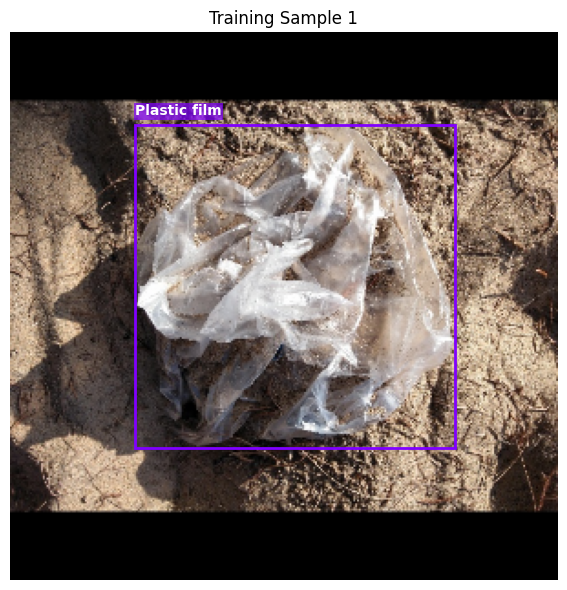


Processing Validation sample 1


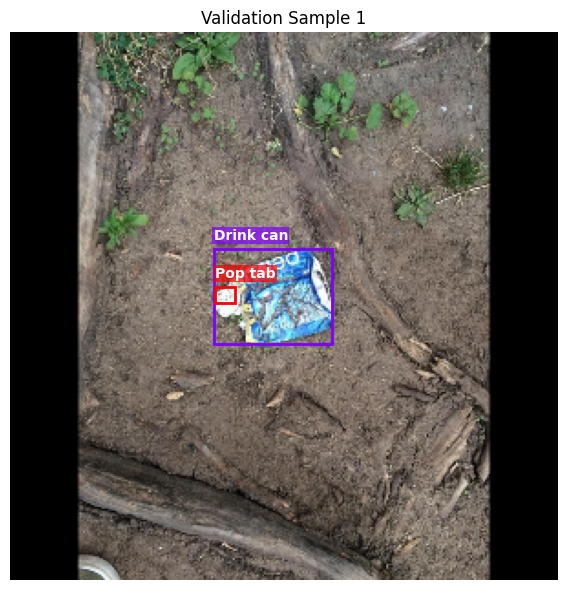


Processing Test sample 1


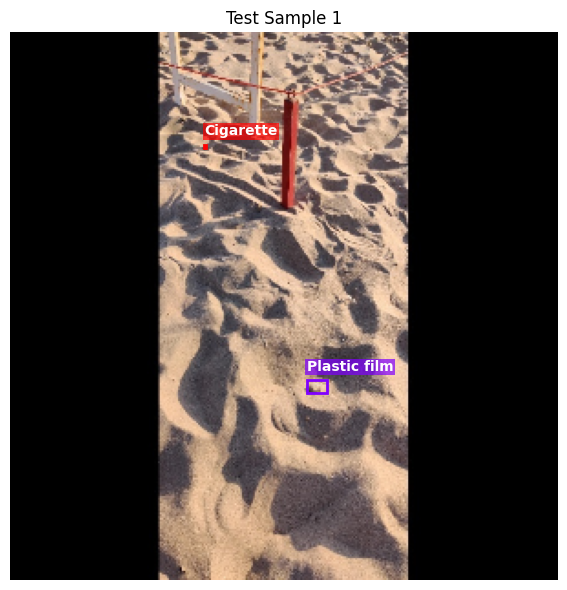

In [8]:
# Get datasets from your existing dataloaders
train_dataset = train_loader.dataset
val_dataset = val_loader.dataset
test_dataset = test_loader.dataset

# Visualize samples
visualize_dataset_samples(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    category_mapping=category_mapping,
    samples_per_split=1,
    figsize=(8, 6)
)

# CUDA Configurations

In [11]:
# Set CUDA flags for better error reporting
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
torch.backends.cudnn.benchmark = False

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Training Configuration and Execution: Setting Up Our Model for Learning

Let me walk you through how we're configuring and training our Faster R-CNN model for trash detection. We'll examine each component and understand how they work together to create an effective learning process.

## GPU Configuration and Memory Management

First, we check if we have access to a GPU and get its specifications:
```python
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**2:.1f}MB")
```
This information helps us understand our computational resources. Think of it like checking the horsepower and fuel capacity of a car before a long journey - we need to know what we're working with to plan accordingly.

## Model Creation and Class Configuration

When we create our model, we add one to the number of classes:
```python
num_classes = len(category_mapping) + 1
model = create_model(num_classes)
```
We add one because in object detection, we need a background class (class 0) in addition to our trash categories. This is similar to how in a game of "I Spy," sometimes the answer might be "nothing interesting here" - our model needs to learn this too.

## Optimizer Configuration: Teaching the Model How to Learn

Our choice of optimizer is SGD (Stochastic Gradient Descent) with specific parameters:
```python
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
```
These parameters are carefully chosen:
- Learning rate (0.005): Like the size of steps our model takes while learning
- Momentum (0.9): Helps the model maintain direction through noisy data, like a ball rolling down a hill
- Weight decay (0.0005): Prevents the model from becoming too confident in specific patterns

## Learning Rate Scheduling: Adapting the Learning Process

The learning rate scheduler helps our model learn more effectively:
```python
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
```
This setup reduces the learning rate every 3 epochs by multiplying it by 0.1. It's like gradually asking a student to be more precise in their answers as they understand more of the subject.

## The Training Loop: Where Learning Happens

Our training process occurs in cycles (epochs), where each epoch consists of:
1. Training on all images in our training set
2. Evaluating performance on our test set
3. Adjusting the learning rate
4. Cleaning up memory

We've wrapped everything in a try-except block to handle errors gracefully:
```python
try:
    # Training code here
except Exception as e:
    print(f"Training failed: {str(e)}")
    # Cleanup code
```

This error handling is crucial - like having safety protocols in a laboratory experiment. If something goes wrong, we ensure we clean up our resources properly.

## Memory Management During Training

Throughout training, we regularly clean up our memory:
```python
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()
```
This is like cleaning your desk between study sessions - it keeps our workspace tidy and prevents resource exhaustion.

The entire process is designed to be both effective and reliable, with careful attention to resource management and error handling. While we're only training for one epoch in this example, the structure is set up to support longer training runs when needed. The combination of proper initialization, careful parameter selection, and robust error handling gives our model the best chance to learn effectively from our trash detection dataset.

In [13]:
if torch.cuda.is_available():
    # Print GPU info
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**2:.1f}MB")

try:
    # Create model
    num_classes = len(category_mapping) + 1
    model = create_model(num_classes)
    model = model.to(device)
    
    # Create optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    
    # Learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)
    
    # Training loop    
    num_epochs = 1
    for epoch in range(num_epochs):
        train_one_epoch_mod(model, optimizer, train_loader, device, epoch, print_freq=10)
        lr_scheduler.step()
        evaluate(model, val_loader, device=device)
        
        # Clear cache between epochs
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

except Exception as e:
    print(f"Training failed: {str(e)}")
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()
    raise e

GPU: NVIDIA GeForce RTX 3060
Total GPU memory: 12287.4MB
Converting to single-process DataLoader...
Memory status - Allocated: 162.9MB, Reserved: 172.0MB
Epoch: [0]  [  0/250]  eta: 0:12:22  lr: 0.000030  loss: 5.0940 (5.0940)  loss_classifier: 4.4413 (4.4413)  loss_box_reg: 0.2375 (0.2375)  loss_objectness: 0.3810 (0.3810)  loss_rpn_box_reg: 0.0342 (0.0342)  time: 2.9692  data: 0.8110  max mem: 8229
Memory status - Allocated: 499.6MB, Reserved: 1054.0MB
Epoch: [0]  [ 10/250]  eta: 0:11:09  lr: 0.000281  loss: 4.9572 (5.0074)  loss_classifier: 4.4016 (4.3881)  loss_box_reg: 0.1743 (0.1900)  loss_objectness: 0.2071 (0.3993)  loss_rpn_box_reg: 0.0184 (0.0301)  time: 2.7904  data: 1.2308  max mem: 8903
Memory status - Allocated: 502.2MB, Reserved: 1090.0MB
Epoch: [0]  [ 20/250]  eta: 0:21:36  lr: 0.000532  loss: 4.8225 (5.0853)  loss_classifier: 4.2586 (4.2358)  loss_box_reg: 0.1743 (0.2096)  loss_objectness: 0.2257 (0.5898)  loss_rpn_box_reg: 0.0256 (0.0501)  time: 5.7707  data: 1.6490  

# Extended Training Phase: Taking Our Model to the Next Level

Let's understand how we're continuing the training of our trash detection model for a more thorough learning experience. This extended training phase is crucial for developing a robust model that can reliably identify different types of trash in various conditions.

## Understanding the Extended Training Process

What we're doing here is similar to moving from basic training to advanced practice in sports. While our initial training gave the model a foundation, these additional epochs allow it to refine its understanding and improve its accuracy. Think of it like a student moving from basic exercises to more complex problem-solving – each repetition builds on previous learning.

```python
num_epochs = 30
```
We've set our training to run for 30 epochs, which means our model will see the entire dataset 30 times. This extended exposure is important because:
- Early epochs help the model learn basic features (like edges and shapes)
- Middle epochs allow it to understand more complex patterns
- Later epochs help fine-tune the model's predictions to be more precise

## Resource Management and Monitoring

The GPU monitoring code is particularly important during extended training:
```python
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**2:.1f}MB")
```
This is like keeping an eye on your car's dashboard during a long journey. We need to know how our computational resources are holding up throughout the extended training process.

## The Extended Training Loop

Our training loop includes several key components that work together:
```python
for epoch in range(num_epochs):
    train_one_epoch_mod(model, optimizer, train_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, test_loader, device=device)
```

Each epoch involves:
1. Training: The model learns from the training data, adjusting its understanding
2. Learning Rate Adjustment: The scheduler reduces the learning rate periodically, helping the model make finer adjustments
3. Evaluation: We check the model's performance on the test set to track improvement
4. Memory Cleanup: We clear unused memory to maintain stable performance

## Memory Management for Sustained Training

The memory management approach becomes even more critical during extended training:
```python
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()
```
This regular cleanup is like taking short breaks during a long study session – it helps maintain optimal performance and prevents resource exhaustion. During a 30-epoch training run, these cleanups ensure our model can continue learning effectively without running into memory issues.

## Error Handling for Long-Running Processes

Our try-except block becomes especially valuable in extended training:
```python
try:
    # Training loop
except Exception as e:
    print(f"Training failed: {str(e)}")
    # Cleanup code
```
This error handling is like having a safety net during a long climbing expedition. If something goes wrong at any point during the 30 epochs, we can catch the error, clean up our resources, and understand what happened.

By running this extended training, we're giving our model the time it needs to develop a deep understanding of trash detection. The combination of multiple epochs, careful resource management, and robust error handling helps ensure our model can learn effectively over this longer training period. Remember to monitor the evaluation metrics during training – they should show a general trend of improvement, though there might be some fluctuations along the way.

In [22]:
#Continue Training
if torch.cuda.is_available():
    # Print GPU info
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**2:.1f}MB")

try:
    # Training loop    
    num_epochs = 30
    for epoch in range(num_epochs):
        train_one_epoch_mod(model, optimizer, train_loader, device, epoch, print_freq=10)
        lr_scheduler.step()
        evaluate(model, val_loader, device=device)
        
        # Clear cache between epochs
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

except Exception as e:
    print(f"Training failed: {str(e)}")
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()
    raise e

GPU: NVIDIA GeForce RTX 3060
Total GPU memory: 12287.4MB
Converting to single-process DataLoader...
Memory status - Allocated: 501.2MB, Reserved: 1012.0MB
Epoch: [0]  [  0/250]  eta: 0:10:42  lr: 0.000030  loss: 0.6947 (0.6947)  loss_classifier: 0.3763 (0.3763)  loss_box_reg: 0.2370 (0.2370)  loss_objectness: 0.0606 (0.0606)  loss_rpn_box_reg: 0.0208 (0.0208)  time: 2.5701  data: 0.8336  max mem: 13341
Memory status - Allocated: 501.0MB, Reserved: 1112.0MB
Epoch: [0]  [ 10/250]  eta: 0:10:46  lr: 0.000281  loss: 0.6151 (0.6289)  loss_classifier: 0.3092 (0.3166)  loss_box_reg: 0.1716 (0.1770)  loss_objectness: 0.1054 (0.1126)  loss_rpn_box_reg: 0.0180 (0.0227)  time: 2.6923  data: 1.1954  max mem: 13341
Memory status - Allocated: 500.7MB, Reserved: 1158.0MB
Epoch: [0]  [ 20/250]  eta: 0:21:32  lr: 0.000532  loss: 0.6925 (0.7508)  loss_classifier: 0.3092 (0.3514)  loss_box_reg: 0.1716 (0.1982)  loss_objectness: 0.1165 (0.1599)  loss_rpn_box_reg: 0.0218 (0.0413)  time: 5.7733  data: 1.622

# Saving Our Trained Model: Preserving Our Work for Future Use

Let's understand exactly what's happening when we save our trained model and why this step is so crucial in the machine learning pipeline. Think of this as carefully preserving an important scientific discovery so it can be used and studied later.

When we call `torch.save(model.state_dict(), model_path)`, we're doing something quite sophisticated. The `state_dict()` method creates a Python dictionary that contains all the learned parameters (weights and biases) of our model. This is like taking a detailed snapshot of our model's brain after it has learned to recognize different types of trash.

Let's break down what this operation actually saves:
```python
torch.save(model.state_dict(), model_path)
```
This line does several important things under the hood:

First, it converts all our model's learned parameters into a format that can be stored on disk. These parameters include all the weights in our neural network's layers - from the early layers that detect basic features like edges and corners, to the deeper layers that recognize specific types of trash items.

Second, it organizes these parameters in a structured way. The state dictionary uses keys that match the names of different parts of our model, making it easy to load these parameters back into a model with the same architecture later. This is similar to how a detailed blueprint allows someone to reconstruct a complex machine exactly as it was designed.

Third, it saves this information to the file specified by `model_path`. This creates a .pth file (PyTorch's standard format) that contains all this information in a compressed format. The file size might be substantial since it contains millions of parameters, but it's much smaller than storing the entire training dataset.

This saving process is crucial for several reasons:
1. We can use this saved model later without having to retrain it from scratch
2. We can share our trained model with others who might want to use it for trash detection
3. We can use this saved state as a starting point for further training or fine-tuning
4. It serves as a checkpoint in case we want to compare different training approaches

Think of it like taking a detailed photograph of a finished sculpture - while it doesn't capture the entire process of creating the sculpture, it preserves the final result in a way that can be studied and appreciated later.

To ensure this saved model will be useful later, it's important to also document:
- The architecture of the model
- The number of classes it was trained to detect
- The format of input images it expects
- Any preprocessing steps required
- The category mapping used during training

This context helps future users understand how to properly use the model we've just saved.

In [25]:
torch.save(model.state_dict(), model_path)

# Evaluating and Visualizing TACO Trash Detection Model

After training our Faster R-CNN model, we need to evaluate its performance and visualize its predictions. This section will show you how to load a trained model and use it to detect trash objects in images, comparing the predictions with ground truth annotations.

# Loading a Trained Model: Understanding the Model Restoration Process

Let's explore how we bring our trained Faster R-CNN model back to life from its saved state. This process is much like carefully reconstructing a complex machine from its blueprint - we need to ensure every piece is in the right place and configured correctly.

The `load_model_checkpoint` function performs this restoration process in several carefully orchestrated steps. Let's understand each one:

## Step 1: Determining the Model's Size
```python
num_classes = len(category_mapping) + 1  # Add 1 for background class
```
First, we need to know exactly how many types of objects our model was trained to detect. We add 1 to account for the background class - this is crucial because our model needs to distinguish between "something interesting" and "nothing of interest" in an image. Think of it like teaching someone to spot specific birds - they need to know both what different birds look like and what "not a bird" looks like.

## Step 2: Creating the Model Architecture
```python
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
```
Here, we're building the skeleton of our model. We start with a pre-trained model because even though we'll replace its learned weights, its architecture - the way layers are connected - must match exactly what we used during training. This is similar to ensuring you have the right type of frame before restoring a classic car - the parts won't fit otherwise.

## Step 3: Customizing the Classifier
```python
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
```
This step is like customizing the final decision-making component of our model. The `FastRCNNPredictor` is responsible for making the final call about what type of trash object it's looking at. We configure it to handle exactly the number of categories we trained it on. This is crucial - if we tried to load weights trained for 10 categories into a model expecting 5, things would go wrong quickly.

## Step 4: Loading the Trained Weights
```python
model.load_state_dict(torch.load(checkpoint_path))
```
Finally, we load all the learned parameters - the wisdom our model gained through training - back into this reconstructed architecture. This is like uploading memories back into a brain: each connection strength, each learned pattern, is restored to exactly where it needs to be. The `load_state_dict` function knows exactly where each piece of information belongs in our model's structure.

Think of this entire process like restoring a master chef's kitchen: first you need the right layout (architecture), then the right tools and equipment (layers and connections), and finally you bring in the chef's accumulated knowledge and experience (trained weights). Only when all these elements are properly in place can the kitchen function as intended.

This careful loading process ensures our model can immediately begin making predictions about trash objects, exactly as it did right after training. The function returns the fully restored model, ready to be used for detecting and classifying trash in new images.

Remember that when using this loaded model, we'll need to use the same preprocessing steps and handle the outputs in the same way as during training. The model expects its inputs to be prepared in a specific way, and it will provide its outputs in the format it was trained to use.

In [26]:
def load_model_checkpoint(checkpoint_path, category_mapping):
    # Create model with the correct number of classes
    num_classes = len(category_mapping) + 1  # Add 1 for background class
    
    # Initialize model architecture
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Replace the classifier with the correct number of classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # Load the trained weights
    model.load_state_dict(torch.load(checkpoint_path))
    return model

<All keys matched successfully>

# Making Predictions: Understanding How Our Model Analyzes New Images

The `predict_single_image` function represents the culmination of our work - it's where our trained model actually performs trash detection on new images. Let's explore how this function carefully processes an image to identify and locate trash objects, similar to how a trained expert would carefully scan a scene.

Let's break down this process step by step:

## Preparing the Model for Prediction

First, we set the model into evaluation mode:
```python
model.eval()
```
This is like telling our expert to switch from learning mode to analysis mode. During training, our model was constantly adjusting its understanding, but now we want it to focus solely on making predictions. This changes how certain model components behave, particularly dropout and batch normalization layers.

We also disable gradient calculations since we're not training:
```python
with torch.no_grad():
```
This is like removing the training wheels - we don't need to track how we could improve our predictions right now, we just want to make them. This saves memory and makes predictions faster.

## Making the Prediction

When we feed an image to our model:
```python
prediction = model([image])[0]
```
This is where the magic happens. Our model analyzes the image through its layers, looking for patterns it learned during training. The process is similar to how a human might scan an image:
1. First, identifying basic shapes and edges
2. Then combining these into more complex patterns
3. Finally recognizing complete objects and their locations

## Filtering the Results

Not all predictions are equally confident, so we filter them:
```python
mask = prediction['scores'] >= confidence_threshold
boxes = prediction['boxes'][mask]
scores = prediction['scores'][mask]
labels = prediction['labels'][mask]
```
This is like having a quality control step. If our model isn't at least 50% confident (by default) about a prediction, we don't include it in our results. This helps prevent false positives - we'd rather miss a piece of trash than incorrectly identify something as trash when it isn't.

## Preparing the Results for Use

The function organizes the results in a clear structure:
```python
result = {
    'boxes': boxes.cpu(),
    'scores': scores.cpu(),
    'labels': labels.cpu()
}
```
Each piece of information serves a specific purpose:
- `boxes`: Where each piece of trash is located (in pixel coordinates)
- `scores`: How confident the model is about each prediction
- `labels`: What type of trash each object is predicted to be

## Memory Management

Finally, we clean up after ourselves:
```python
if torch.cuda.is_available():
    torch.cuda.empty_cache()
```
This is like cleaning our workspace after completing an analysis. It ensures we're ready for the next prediction and aren't wasting resources.

The end result is a clean, organized presentation of what trash objects the model found in the image, how sure it is about each one, and exactly where they are located. This information can then be used to visualize the detections on the image or feed into a larger system for automated trash detection and sorting.

Remember that the quality of predictions depends on several factors:
- How well the model was trained
- How similar the new images are to the training data
- The chosen confidence threshold
- The quality and clarity of the input image

By understanding how this prediction process works, we can better interpret its results and adjust parameters like the confidence threshold to balance between catching all trash objects and avoiding false detections.

In [ ]:
def predict_single_image(model, image, device, confidence_threshold=0.5):
    model.eval()  # Set model to evaluation mode
    
    with torch.no_grad():  # Disable gradient calculation
        # Move image to the correct device (GPU/CPU)
        image = image.to(device)
        
        # Get model predictions
        prediction = model([image])[0]
        
        # Filter predictions by confidence threshold
        mask = prediction['scores'] >= confidence_threshold
        boxes = prediction['boxes'][mask]
        scores = prediction['scores'][mask]
        labels = prediction['labels'][mask]
        
        # Move results back to CPU for visualization
        result = {
            'boxes': boxes.cpu(),
            'scores': scores.cpu(),
            'labels': labels.cpu()
        }
        
        # Clean up GPU memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            
        return result

# Understanding Result Visualization: Making Our Model's Predictions Interpretable

Let's explore how we visualize and compare our model's predictions with ground truth labels. This visualization system helps us understand both what our model sees and how it compares to human annotations. Let's break down each component of this sophisticated visualization pipeline.

## Converting Image Coordinates: The Foundation

First, we have tools to handle the coordinate systems that our model works with:

```python
def denormalize_boxes_to_fixed_size(boxes, fixed_size=(300, 300)):
```
This function converts from normalized coordinates (0-1 range) to actual pixel coordinates. Think of it like converting from percentages to actual measurements - if something is 50% across the image, this function figures out exactly how many pixels that represents in our 300x300 display.

## Image Processing: Making Things Visible

```python
def denormalize_image(image):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
```
This function reverses the normalization we applied during training. It's like developing a photograph - we're converting from the specialized format our model uses back to something human eyes can understand. The specific numbers (mean and standard deviation) match what we used during training, ensuring consistency.

## The Main Visualization Function

The heart of our visualization system is the `visualize_prediction` function. It creates a side-by-side comparison showing:
1. Our model's predictions (left side)
2. The ground truth annotations (right side)

This parallel view helps us evaluate our model's performance at a glance. Let's look at key aspects:

### Setting Up the Display
```python
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
```
This creates our two-panel display, like setting up two screens side by side for comparison.

### Drawing the Predictions
```python
for box, score, label in zip(prediction['boxes'], prediction['scores'], prediction['labels']):
    if score >= confidence_threshold:
        # Draw box and label code
```
For each prediction that meets our confidence threshold, we:
- Draw a red box showing where the model thinks it found trash
- Add a label showing what type of trash it thinks it found
- Include the confidence score (how sure the model is)

### Drawing Ground Truth
```python
for box, label in zip(target['boxes'], target['labels']):
    # Draw box and label code
```
Similarly, we draw green boxes for the ground truth annotations, showing what a human annotator marked as trash in the image.

### Visual Clarity Features
The function includes several features to make the visualization clear and informative:
- Different colors for predictions (red) and ground truth (green)
- Text labels with white backgrounds for readability
- No axes or grid lines to keep the focus on the detections
- Proper scaling to maintain image proportions

## Why This Visualization Matters

This visualization system helps us in several ways:
1. **Accuracy Assessment**: We can quickly see if our model is finding the right objects
2. **Error Analysis**: We can identify whether the model tends to miss objects or make false detections
3. **Confidence Understanding**: We can see how confident the model is in its correct and incorrect predictions
4. **Category Performance**: We can assess if the model performs better with certain types of trash

By providing this clear visual comparison, we can better understand our model's strengths and weaknesses, guiding future improvements in our trash detection system.

Remember that analyzing these visualizations is crucial for:
- Fine-tuning the confidence threshold
- Identifying categories that need more training data
- Understanding the model's real-world performance capabilities
- Communicating results to non-technical stakeholders

In [ ]:
def denormalize_boxes_to_fixed_size(boxes, fixed_size=(300, 300)):
    """
    Denormalize bounding boxes from normalized coordinates to a fixed size (e.g., 300x300).
    
    Args:
        boxes (Tensor): Normalized bounding boxes [x1, y1, x2, y2] in the range [0, 1].
        fixed_size (Tuple[int, int]): Fixed output dimensions (width, height) (e.g., 300x300).

    Returns:
        Tensor: Denormalized bounding boxes to the fixed size.
    """
    fixed_w, fixed_h = fixed_size

    # Scale normalized boxes to the fixed size
    boxes[:, [0, 2]] *= fixed_w  # Scale x-coordinates
    boxes[:, [1, 3]] *= fixed_h  # Scale y-coordinates

    return boxes

def denormalize_image(image):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return image * std + mean

def resize_image_to_fixed_size(image, fixed_size=(300, 300)):
    """
    Resize the given image to a fixed size (e.g., 300x300).
    
    Args:
        image (np.ndarray): Image array.
        fixed_size (Tuple[int, int]): Fixed output dimensions (width, height) (e.g., 300x300).
        
    Returns:
        np.ndarray: Resized image.
    """
    return cv2.resize(image, fixed_size)


def visualize_prediction(image, prediction, target, category_mapping,
                               fixed_size=(300, 300), confidence_threshold=0.5, figsize=(12, 8)):
    """
    Visualize predictions and ground truth for object detection on a fixed size image.
    
    Args:
        image (Tensor): Input image tensor.
        prediction (Dict): Model predictions containing 'boxes', 'scores', and 'labels'.
        target (Dict): Ground truth containing 'boxes' and 'labels'.
        category_mapping (Dict): Mapping of category IDs to names.
        fixed_size (Tuple[int, int]): Fixed output dimensions (width, height) (e.g., 300x300).
        confidence_threshold (float): Minimum score threshold for displaying predictions.
        figsize (Tuple[int, int]): Size of the visualization figure.
    """
    fixed_w, fixed_h = fixed_size

    # Resize image to fixed size
    # image_np = resize_image_to_fixed_size(image.permute(1, 2, 0).cpu().numpy(), fixed_size)
    # image_np = np.clip(image_np * 255, 0, 255).astype(np.uint8)
    image_np = denormalize_image(image)
    image_np = denormalize_image(image)
    image_np = image_np.permute(1, 2, 0).numpy()
    image_np = np.clip(image_np, 0, 1)

    # Denormalize bounding boxes to fixed size
    prediction['boxes'] = denormalize_boxes_to_fixed_size(prediction['boxes'], fixed_size)
    target['boxes'] = denormalize_boxes_to_fixed_size(target['boxes'], fixed_size)

    # Create a figure with two subplots: predictions and ground truth
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('Object Detection Results (Fixed Size)', fontsize=16)

    # Plot predictions (left subplot)
    ax1.imshow(image_np)
    ax1.set_title('Predictions')

    # Draw predicted boxes in red
    for box, score, label in zip(prediction['boxes'], prediction['scores'], prediction['labels']):
        if score >= confidence_threshold:
            x1, y1, x2, y2 = box.numpy()
            rect = patches.Rectangle(
                (x1, y1), x2-x1, y2-y1,
                linewidth=2,
                edgecolor='r',
                facecolor='none'
            )
            ax1.add_patch(rect)

            # Add label and confidence score
            label_name = category_mapping.get(label.item(), f"Class {label.item()}")
            ax1.text(
                x1, y1-5,
                f'{label_name}: {score:.2f}',
                color='red',
                fontsize=8,
                bbox=dict(facecolor='white', alpha=0.8)
            )

    # Plot ground truth (right subplot)
    ax2.imshow(image_np)
    ax2.set_title('Ground Truth')

    # Draw ground truth boxes in green
    for box, label in zip(target['boxes'], target['labels']):
        x1, y1, x2, y2 = box.numpy()
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=2,
            edgecolor='g',
            facecolor='none'
        )
        ax2.add_patch(rect)

        # Add label
        label_name = category_mapping.get(label.item(), f"Class {label.item()}")
        ax2.text(
            x1, y1-5,
            label_name,
            color='green',
            fontsize=8,
            bbox=dict(facecolor='white', alpha=0.8)
        )

    # Remove axes for cleaner visualization
    ax1.axis('off')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()


# Model Evaluation: Understanding How We Test Our Trained Model's Performance

Let's explore how we systematically evaluate our trained trash detection model using the `evaluate_samples` function. This function helps us understand how well our model performs on real-world examples by examining its predictions in detail.

## Setting Up the Evaluation Environment

First, we need to prepare our testing environment:
```python
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
```
This step ensures we're using the best available computing resources for our evaluation. Think of it like choosing the right laboratory equipment for conducting experiments - we want the most efficient tools available.

Next, we load our trained model:
```python
model = load_model_checkpoint(model_path, category_mapping)
```
This is like retrieving our trained expert from where we stored their expertise. The model contains all the knowledge it gained during training, ready to be applied to new images.

## Selecting Test Samples

We carefully choose which images to evaluate:
```python
indices = random.sample(range(dataset_size), min(num_samples, dataset_size))
```
This random sampling approach is similar to how quality control might randomly select products from a production line for testing. By looking at random samples, we get a more representative view of how our model performs across different situations.

## The Evaluation Process

For each selected image, we perform a thorough analysis:

```python
image, target = test_loader.dataset[idx]
prediction = predict_single_image(
    model=model,
    image=image,
    device=device,
    confidence_threshold=confidence_threshold
)
```
This is like conducting a controlled experiment where we:
1. Take a test image (our experiment subject)
2. Ask our model to analyze it (run the experiment)
3. Record the results (predictions)

We then present the results in a clear, detailed manner:
```python
print(f"\nSample {idx}:")
print(f"Found {len(prediction['boxes'])} objects")
```
For each detected object, we show:
- What type of trash it thinks it found (the category)
- How confident it is about its prediction (the score)
- Where in the image it found the object (through visualization)

## Visual Verification

The function includes visualization to help us understand the results:
```python
visualize_prediction(
    image=image,
    prediction=prediction,
    target=target,
    category_mapping=category_mapping,
    confidence_threshold=confidence_threshold
)
```
This visual representation helps us see:
- Where the model detected trash objects
- How accurate its detections are compared to the ground truth
- Whether it missed any objects or made false detections

## Memory Management

Throughout the evaluation, we maintain clean memory usage:
```python
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()
```
This regular cleanup ensures we can evaluate many samples without running into memory issues, similar to cleaning lab equipment between experiments to ensure accurate results.

This evaluation process gives us a comprehensive view of our model's performance, helping us understand:
- How accurate its predictions are
- What types of trash it identifies well
- Where it might make mistakes
- How confident it is in different situations


In [ ]:
def evaluate_samples(model_path, test_loader, category_mapping, 
                    num_samples=5, confidence_threshold=0.5):
    # Set up device (GPU if available, else CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load and prepare model
    model = load_model_checkpoint(model_path, category_mapping)
    # model = model.to(device)
    # model.eval()
    
    # Select random samples to evaluate
    dataset_size = len(test_loader.dataset)
    indices = random.sample(range(dataset_size), min(num_samples, dataset_size))
    
    # Process each sample
    for idx in indices:
        # Get a single sample
        image, target = test_loader.dataset[idx]
        
        # Make prediction
        prediction = predict_single_image(
            model=model,
            image=image,
            device=device,
            confidence_threshold=confidence_threshold
        )
        
        # Print detection results
        print(f"\nSample {idx}:")
        print(f"Found {len(prediction['boxes'])} objects")
        print("\nPredicted objects:")
        for label, score in zip(prediction['labels'], prediction['scores']):
            if score >= confidence_threshold:
                label_name = category_mapping.get(label.item(), f"Class {label.item()}")
                print(f"{label_name}: {score:.2f}")
        
        # Visualize results
        visualize_prediction(
            image=image,
            prediction=prediction,
            target=target,
            category_mapping=category_mapping,
            confidence_threshold=confidence_threshold
        )
        
        # Clean up memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

# Using the Evaluation Code

## Understanding the Visualization

The evaluation creates side-by-side comparisons where:
- The left image shows model predictions with red boxes and confidence scores
- The right image shows ground truth annotations with green boxes
- Each box is labeled with the trash category name
- Predictions below the confidence threshold are filtered out

This visualization helps you:
1. Assess detection accuracy
2. Identify false positives and false negatives
3. Understand model confidence levels
4. Spot patterns in model performance
5. Find areas for improvement in training

## Tips for Evaluation

1. Adjust the confidence threshold based on your needs:
   - Higher threshold (e.g., 0.7) for more confident predictions
   - Lower threshold (e.g., 0.3) to see more potential detections

2. Evaluate different types of images:
   - Various lighting conditions
   - Different backgrounds
   - Multiple object scenarios
   - Partially obscured objects

3. Pay attention to:
   - False positives (predictions where there are no objects)
   - Missed detections (objects in ground truth but not predicted)
   - Confidence scores for correct vs. incorrect predictions
   - Multiple detections of the same object

4. Remember to clear GPU memory regularly when processing many images

Here's how to use the evaluation functions:

Using device: cuda
Model loaded successfully

Sample 275:
Found 6 objects

Predicted objects:
Plastic film: 0.28
Plastic film: 0.24
Plastic film: 0.20
Plastic film: 0.19
Plastic film: 0.19
Plastic film: 0.15


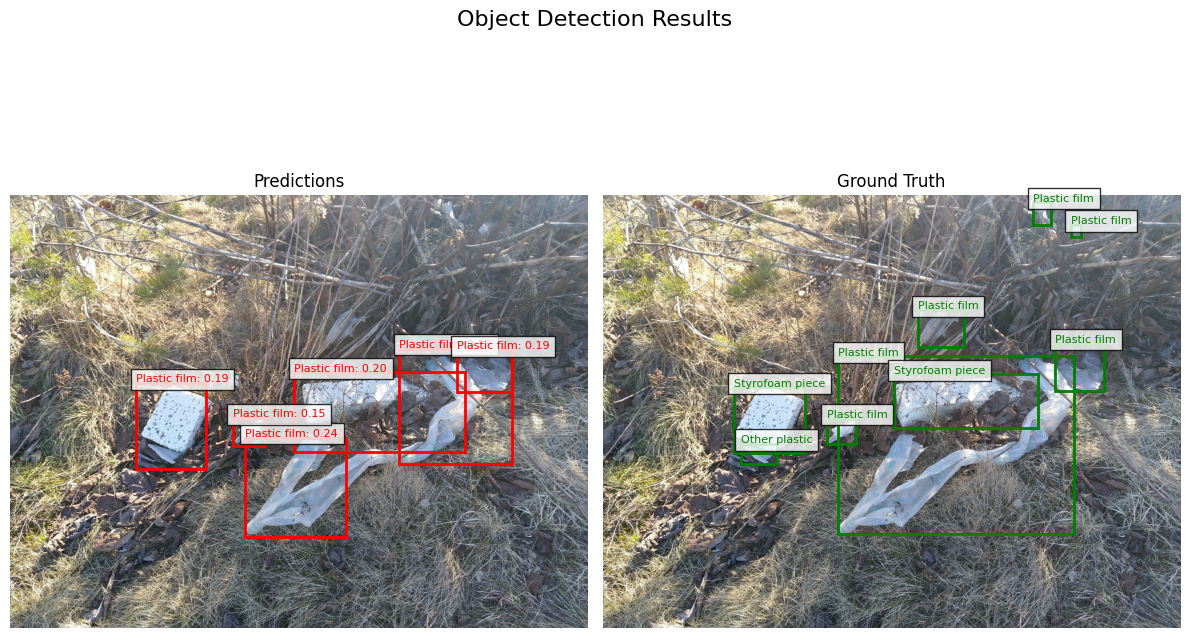

In [44]:
# Evaluate samples
evaluate_samples(
    model_path=model_path,
    test_loader=test_loader,
    category_mapping=category_mapping,
    num_samples=1,
    confidence_threshold=0.15
)